# Registro
Este notebook, para correto funcionamento, deve utilizar o OpenCV em sua versão 3.4.2.

In [1]:
import numpy as np
import cv2
import os
import random
from utils import *

print('OpenCV version:', cv2.__version__)
try:
    %matplotlib qt5
except:
    %matplotlib

OpenCV version: 3.4.2


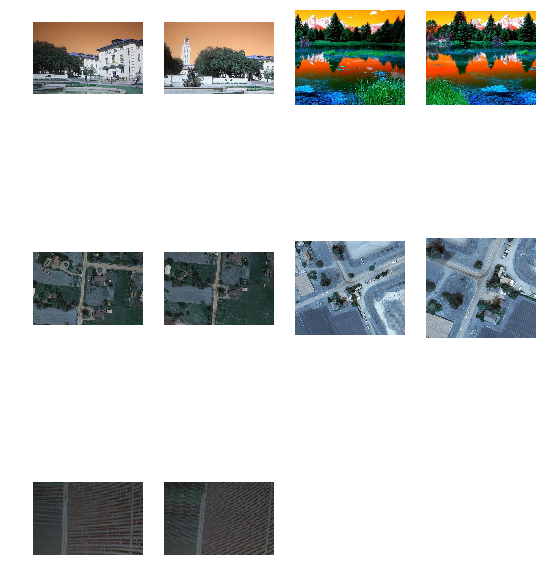

In [2]:
# Load images
image_dir = 'imagens_registro/'
image_names = sorted(os.listdir(image_dir))

images = [cv2.imread(os.path.join(image_dir,name)) for name in image_names]

plot_images(images,resize=3)

**Passo 1:** converter as imagens coloridas de entrada em imagens de niveis de cinza

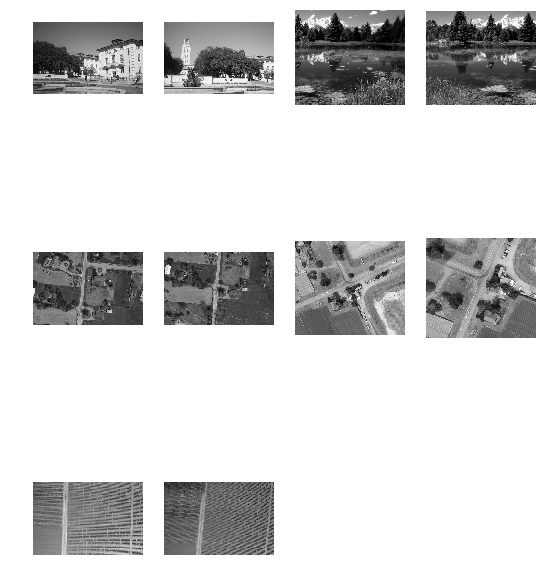

In [3]:
# Convert to gray scale
images_gray = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\
               for image in images]
plot_images(images_gray, resize=3)

**Passo 2:**  encontrar pontos de interesse e descritores invariantes locais para o par de imagens.


Neste passo vamos aplicar o algoritmo [SIFT](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html) (*scale invariant feature transformation*) para extrair pontos de interesse e descritores invariantes.

Para caso aja algum problema como   
<font color="red">AttributeError</font>: module 'cv2.cv2' has no attribute 'xfeatures2d'

Instalar:
```bash
pip install opencv-contrib-python
```

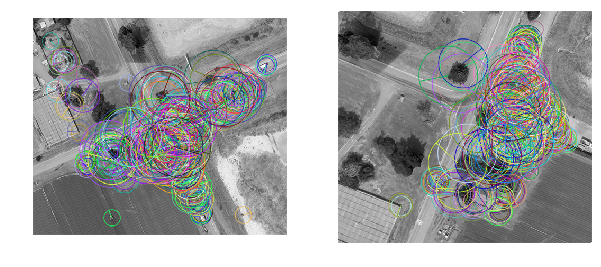

In [55]:
PAIR_INDEX = 3
ALGORITHM = 'orb'

if ALGORITHM == 'sift':
    # Construct a SIFT object
    norm = cv2.NORM_L2
    detector = cv2.xfeatures2d.SIFT_create()
elif ALGORITHM == 'surf':
    detector = cv2.xfeatures2d.SURF_create()
    norm = cv2.NORM_L2
elif ALGORITHM == 'brief':
    # Initiate FAST detector
    norm = cv2.NORM_HAMMING
#     detector = cv2.xfeatures2d.StarDetector_create()
    detector = cv2.xfeatures2d.SIFT_create()
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
elif ALGORITHM == 'orb':
    # Initialize ORB object
    norm = cv2.NORM_HAMMING
    detector = cv2.ORB_create()

# Detect key points
key_points1 = detector.detect(images_gray[2*PAIR_INDEX],None)
img1=cv2.drawKeypoints(images_gray[2*PAIR_INDEX],key_points1, images_gray[2*PAIR_INDEX],
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
key_points2 = detector.detect(images_gray[2*PAIR_INDEX+1],None)
img2=cv2.drawKeypoints(images_gray[2*PAIR_INDEX+1],key_points2, images_gray[2*PAIR_INDEX+1],
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Compute descritors
if not ALGORITHM == 'brief':
    _, des1 = detector.compute(images_gray[2*PAIR_INDEX],key_points1)
    _, des2 = detector.compute(images_gray[2*PAIR_INDEX+1],key_points2)
else:
    # compute the descriptors with BRIEF
    key_points1, des1 = brief.compute(images_gray[2*PAIR_INDEX], key_points1)
    key_points2, des2 = brief.compute(images_gray[2*PAIR_INDEX+1], key_points2)

# Visualize output
plot_images([img1,img2],num_columns=2)

**Passo 3:** computar distâncias (similaridades) entre cada descritor das duas imagens  
https://docs.opencv.org/3.4.3/dc/dc3/tutorial_py_matcher.html

In [56]:
# create BFMatcher (brute force) object
bf = cv2.BFMatcher(norm, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)

**Passo 4:** selecionar as melhores correspondˆencias para cada descritor de imagem.

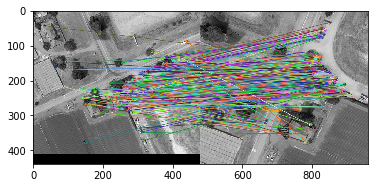

(<matplotlib.image.AxesImage at 0x7f9b23de15f8>, None)

In [60]:
# Number of matches to be selected

# Sort them in the order of their distance. (The lower the better)
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 50 matches.
img3 = cv2.drawMatches(images_gray[2*PAIR_INDEX],key_points1,images_gray[2*PAIR_INDEX+1],
                      key_points2,matches, flags=2,outImg=images_gray[0])
plt.imshow(img3),plt.show()

**Passo 5:** executar  a  técnica  RANSAC  (RANdom  SAmple  Consensus)  para  estimar  a  matriz  de  homografia(cv2.findHomography).

In [61]:
# Extract points
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for index, match in enumerate(matches):
    points1[index,:] = key_points1[match.queryIdx].pt # source
    points2[index,:] = key_points2[match.trainIdx].pt # destiny

# Find homography using RANSAC
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)
np.printoptions(precision=3)
print(h)

[[ 1.22044468e+00  1.12228738e+00 -2.33196258e+02]
 [-1.10425713e+00  1.19621756e+00  2.10556840e+02]
 [ 9.95996405e-05  7.83459315e-06  1.00000000e+00]]


**Passo 6:** aplicar uma proje ̧c ̃ao de perspectiva (cv2.warpPerspective) para alinhar as imagens.

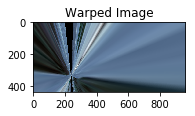

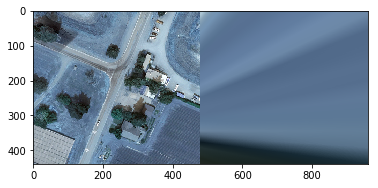

In [46]:
img_right = images[2*PAIR_INDEX] # Right
img_left= images[2*PAIR_INDEX+1] # Left

dst = cv2.warpPerspective(img_right,h,(img_left.shape[1] + img_right.shape[1], img_left.shape[0]))
plt.subplot(122),plt.imshow(dst),plt.title('Warped Image')
plt.show()
plt.figure()
dst[0:img_left.shape[0], 0:img_left.shape[1]] = img_left
plt.imshow(dst)
plt.show()

### Referências
Converter para escala de cinza  
https://techtutorialsx.com/2018/06/02/python-opencv-converting-an-image-to-gray-scale/  

Encontrar descritores SIFT  
https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html  

Fazer o match de features  
https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html  

Achar a matriz de homografia  
https://docs.opencv.org/trunk/d1/de0/tutorial_py_feature_homography.html  
Usando RANSAC  
https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/  

Image Stitching using OpenCV  
https://towardsdatascience.com/image-stitching-using-opencv-817779c86a83  

Curiosidade sobre enumerate em Python  
https://www.geeksforgeeks.org/enumerate-in-python/  